<a href="https://colab.research.google.com/github/khipucode/phd_data_and_codes/blob/main/3_3_1_2_graficos_simulados_OFCs_MZM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [575]:
import math as mt
import math
import numpy as np     # library for vector operation
from mpmath import *   # library for bessel function
import matplotlib.pyplot as plt
from google.colab import files
import csv


# Parâmetros dos moduladores
#Vpi_pm1  = 3
Vpi_mz1  = 2.4
pi = 3.1416
#---------------------------Driving voltage ------------------------------------
#----------PM --------- Potências de entrada em dBm nas portas dos moduladores
#Ppm1     = 28.91   ;  Apm1  = pi*10**((Ppm1-10)/20)/Vpi_pm1     ;   Vpm1   =  Vpi_pm1*Apm1/pi   ; ang1pm = 0   ;  Upm1   =  0       ;     Tpm1  =  (pi*Upm1/Vpi_pm1);
#---------MZM --------
Pmz1a    = 22.3  ;  Amz1a   = pi*10**((Pmz1a-10)/20)/Vpi_mz1  ;   V1a   =  Vpi_mz1*Amz1a/pi   ;  ang1a  = 0  ;  Umz1a  = Vpi_mz1/2 ;    Th1a  =  (pi*Umz1a/Vpi_mz1);
Pmz1b    = 23.9  ;   Amz1b   = pi*10**((Pmz1b-10)/20)/Vpi_mz1 ;   V1b   =  Vpi_mz1*Amz1b/pi   ;  ang1b  = 0  ;  Umz1b  =  0;            Th1b  =  (pi*Umz1b/Vpi_mz1);

'''
# Condição de planicidade - Usar para encontrar um pente plano a partir da potência maior entre os dois braços
Amz1b  = Amz1a + pi/2;
V1b    = Vpi_mz1*Amz1b/pi
Pmz1b  = 10*mt.log10(10*V1b**2)
'''
'''
# --------------- Simulações usando A_x -------------------
Amz1a  = 8.64 #4.97 #
Amz1b  = 11.78 #6.54 #
V1a   = Vpi_mz1*Amz1a/pi ; Pmz1a  = 10*mt.log10(10*V1a**2)
V1b   = Vpi_mz1*Amz1b/pi ; Pmz1b  = 10*mt.log10(10*V1b**2)
# --------------- Simulações usando A_x -------------------

# Dados usados
print('-----------------Dados usados ------------------')
print('Pmz1a        =',round(Pmz1a,2),' Amz1a =', round(Amz1a,2))
print('Pmz1b        =',round(Pmz1b,2) ,' Amz1b =', round(Amz1b,2))
print('Diferença Ax =', round(Amz1b - Amz1a,2))
# ==============================================================================

'''

#if P_cw is inside the MZ vector, this will multiply the number of times there are MZs, so P_cw should use
P_cw    = 1
#num_mzm = 2
#P_cw    = P_cw**(1/3)

#----------------------------TESTING VALUES------------------------------------
up_m  =  61   # number of generated SLs for MZ
noise = 10**-7; noise_dBm = 10*log10(noise)



In [576]:
#---------------------------- Preenchimento do vector MZ
top_m = int((up_m-1)/2)
ind_m = range(-top_m,top_m+1)

def vector_e_mzm(ind_m, Amz1a, Amz1b, Th1a, Th1b, ang1a, ang1b, P_cw):
 vector_mz = []
 for m in ind_m:
   J_m_Amz1a = besselj(m,Amz1a)
   J_m_Amz1b = besselj(m,Amz1b)
   temp = P_cw*0.5*J_m_Amz1a*exp(j*(m*ang1a + Th1a)) + P_cw*0.5*J_m_Amz1b*exp(j*(m*ang1b + Th1b))
   vector_mz.append(temp)
 return vector_mz


#------------function calculate Intensity and add noise----------------
#  Usa um vetor de campo elétrico e calcula E.^2 e adiciona ruido
def find_Iout_add_noise(up_vec, Vector_efield_all, noise):
 temp2 = [abs(k2) for k2 in Vector_efield_all]
 Vector_Iout_all = np.square(temp2)
 ax_vector_comb  = []   # dominio do vetor resultante
 top_k = int((up_vec-1)/2)
 ax_vector_comb = range(-top_k,top_k+1)
 Comb_plot     = []    # vector usado para considerar o ruido
 Comb_plot_dBm = []    # vector usado para considerar o ruido en dBm
 for k1 in range(up_vec):
    temp  = Vector_Iout_all[k1]
    if temp < noise:
      Comb_plot.append(0)
      Comb_plot_dBm.append(10*log10(noise))
    else:
      Comb_plot.append(Vector_Iout_all[k1])
      Comb_plot_dBm.append(10*log10(temp))

 return ax_vector_comb,Comb_plot,Comb_plot_dBm

# -------------------------------------------------------------------------
# Esta função Reduz o tamanho do vector Comb (que já tem ruido) para um valor
# desejado, neste caso não importa se o vector está em mW ou dBm
# up_vec = tamanho atual, vec_comb = vector_actual, up_new = tamanho requerido

def reduct_vector(up_act, vec_comb, up_new):
 # up_act = tamanho atual do vector vec_comb
 a = int((up_act-up_new)/2)
 b = int(a + up_new)
 c = int((up_new-1)/2)
 ax_rang = range(-c,c+1)
 ax_new_list = list(ax_rang)
 new_vcomb = []
 for k in range(a,b):
  new_vcomb.append(vec_comb[k])

 return ax_new_list, new_vcomb
#--------------------------------------end function
# SAÍDA: lista novo dominio do comb , comb com dominio maior
#----------------------------------------------------------------------------
# Esta função aumenta o  o tamanho do vector Comb (que já tem ruido) para um
# valor desejado  unid = 1 -> em mW  ou otro em dBm, noise = usado no sistema

def increase_vector(up_act, vec_comb, up_new, unid, noise):
 # (ax_new, new_vcomb) = increase_vector(up_act, vec_comb, up_new, unid, noise)
 rg = int((up_new - 1)/2)
 a1 = int((up_new - up_act)/2)
 a2 = int(a1 + up_act)
 ax_rang = range(-rg, rg + 1)
 ax_new = list(ax_rang)
 new_vcomb = []
 t1 = 0
 for k in range(up_new):
  if k < a1  or k > a2-1:
    if unid == 1:
     new_vcomb.append(0)
    else:
     new_vcomb.append(10*math.log10(noise))
  else:
   new_vcomb.append(vec_comb[t1])
   t1 = t1 + 1
 return ax_new, new_vcomb

def ploting_sl2(axrange,namex, comb_dBm, sistem, lim_sup, lim_lat):
    # Cria uma figura e um eixo para o gráfico
    fig, ax = plt.subplots(figsize=(9, 4.5), tight_layout=True)


    # Cria o gráfico stem
    ax.stem(axrange,comb_dBm,
              bottom = noise_dBm,
              use_line_collection = True, linefmt='blue', markerfmt='bo')  #magenta red blue kiwi


    # Define o título do gráfico com o valor da variável sistem
    ax.set_title('Resposta do '+sistem+' em dB', pad=14)

    tam_let  = 18
    # Define os rótulos dos eixos
    ax.set_xlabel('$'+namex+'$', fontsize=tam_let)
    ax.set_ylabel('$10 log(I_{'+sistem+'}/I_{IN})$ (dB)', fontsize=tam_let)
    #ax.set_ylabel('Potência (dBm)', fontsize=tam_let)
    ax.tick_params(axis='both', which='major', labelsize=tam_let)
    ax.grid(True, linestyle='--') # Define as linhas do grid como puntilhadas

    '''
    # Criando um segundo conjunto de eixos que compartilha o mesmo eixo x
    ax2 = ax.twinx()
    # Plotando os dados no eixo secundário
    ax2.set_ylabel('Potência (dBm)', fontsize=tam_let, color='r')
    # Configurando a cor do eixo y para corresponder à cor dos dados
    ax2.tick_params(axis='y', labelcolor='r',which='major', labelsize=tam_let)
    ax2.set_ylim(-72, lim_sup)
    ax2.set_yticks(range(-70, lim_sup+1, 10))
    '''

    ax.set_ylim(-72, lim_sup)
    ax.set_xlim(-lim_lat-0.5, lim_lat + 0.5)
    ax.set_yticks(range(-70, lim_sup+1, 10))

    # Exibe o gráfico
    plt.show()

# analise de SD e AV

def analise_SD_AV(vec_SL, eN):
  up_x = len(vec_SL)  #up_m  Tamanho do Vetor gerado por MSL
  print('Tamanho do vector de saida do EOM :', up_x)
  #Quantidade de SLs avaliadas
  print('eN =', eN)
  ia = int((up_x - eN-2)/2+1)
  ib = int((up_x + eN-2)/2+1)

  #print('Faixa entre inicio e final ia=',ia, 'ib=',ib)
  # Encontramos o vetor central a ser avaliado
  v_analyze = []
  for k in range(ia,ib):
    v_analyze.append(vec_SL[k])

  #print('Fator de variação SLs avaliadas   --:', np.std(v_analyze)/np.mean(v_analyze))
  #print('STD: ', np.std(v_analyze),' Média ',np.mean(v_analyze))
  menor = min(v_analyze)
  men_dB = 10*log10(menor)
  maior = max(v_analyze)
  mai_dB = 10*log10(maior)
  dif  = maior - menor
  dif_dB_1  = mai_dB - men_dB
  # Desvio padrão das SLs avaliadas
  print('SD =', round(np.std(v_analyze), 5))
  print('CV =', round(100*np.std(v_analyze)/np.mean(v_analyze), 5))
  #Diferença entre mai e men (dB)
  print('AV =', round(dif_dB_1, 5))

  #PLOTS
  '''
  plt.stem(vec_mz)
  plt.show()
  #plt.stem(Imz_Iin_dBm)
  #plt.show()
  plt.stem(v_analyze)
  plt.show()
  '''
  #plt.stem(v_analyze)
  #plt.show()

# Figura 3.14 (a)





<ipython-input-576-3fc26f7dbdd6>:85: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax.stem(axrange,comb_dBm,


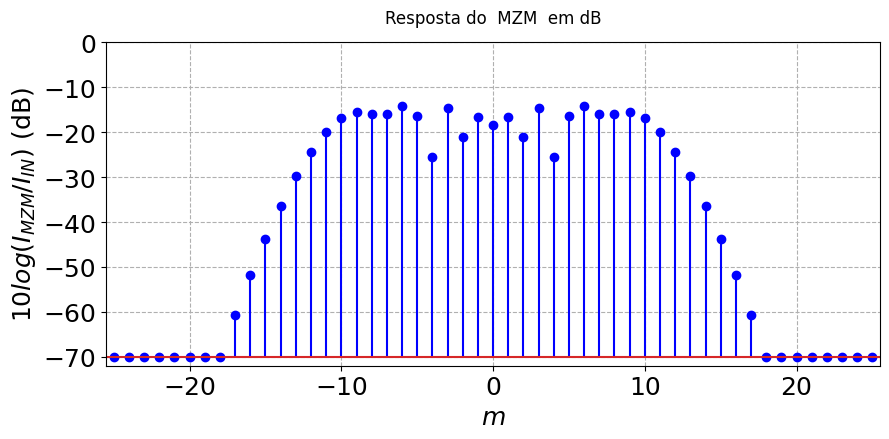

In [577]:
Amz1a = 8
Amz1b = 11
(Vector_mz) = vector_e_mzm(ind_m, Amz1a, Amz1b, Th1a, Th1b, ang1a, ang1b, P_cw)
#-------------- PLOTAR AS SLs GERADAS PELO MZM -------------------------
# usa-se a linha onde é gerada os valores do campo eletrico e o tamanho do vector mz
a = 1
# noise  = -200 # usado para plotar limite menor de ruido
(ax_mz,comb_mz,comb_mz_dBm) = find_Iout_add_noise(up_m, Vector_mz, noise)
sistem2 = ' MZM '
name_x = 'm'
sup_mz  = 0
lat_mz  = 25
ploting_sl2(ax_mz,name_x,comb_mz_dBm,sistem2, sup_mz,lat_mz)

In [578]:
# Pente do MZM a ser analisado
vec_SL = comb_mz  # Vetor de intensidade em mW
eN     = 13          # Numero de SLs a ser analisadas
analise_SD_AV(vec_SL, eN)



Tamanho do vector de saida do EOM : 61
eN = 13
SD = 0.01244
CV = 59.71367
AV = 11.35102


# Figura 3.14 (b)

<ipython-input-576-3fc26f7dbdd6>:85: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax.stem(axrange,comb_dBm,


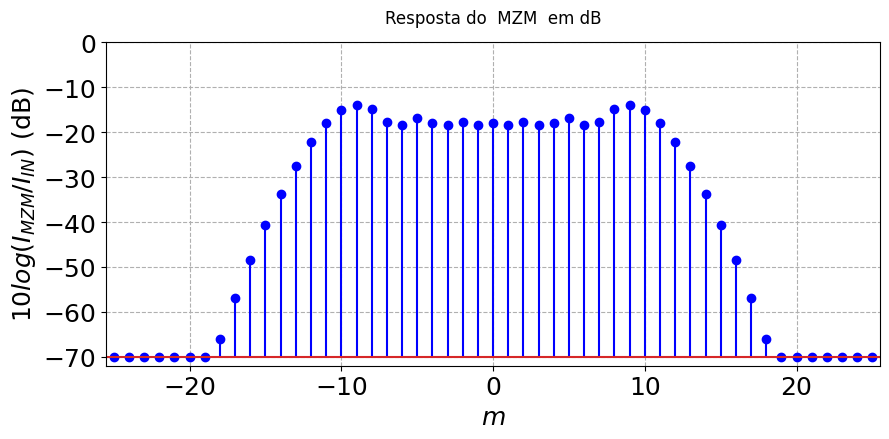

In [579]:
Amz1a = 9.78
Amz1b = 11.35
(Vector_mz) = vector_e_mzm(ind_m, Amz1a, Amz1b, Th1a, Th1b, ang1a, ang1b, P_cw)
#-------------- PLOTAR AS SLs GERADAS PELO MZM -------------------------
# usa-se a linha onde é gerada os valores do campo eletrico e o tamanho do vector mz
a = 1
# noise  = -200 # usado para plotar limite menor de ruido
(ax_mz,comb_mz,comb_mz_dBm) = find_Iout_add_noise(up_m, Vector_mz, noise)
sistem2 = ' MZM '
name_x = 'm'
sup_mz  = 0
lat_mz  = 25
ploting_sl2(ax_mz,name_x,comb_mz_dBm,sistem2, sup_mz,lat_mz)

In [580]:
# Pente do MZM a ser analisado
vec_SL = comb_mz  # Vetor de intensidade em mW
eN     = 19          # Numero de SLs a ser analisadas
analise_SD_AV(vec_SL, eN)

Tamanho do vector de saida do EOM : 61
eN = 19
SD = 0.00887
CV = 43.25176
AV = 4.55295


# Figura 3.15 (a)

<ipython-input-576-3fc26f7dbdd6>:85: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax.stem(axrange,comb_dBm,


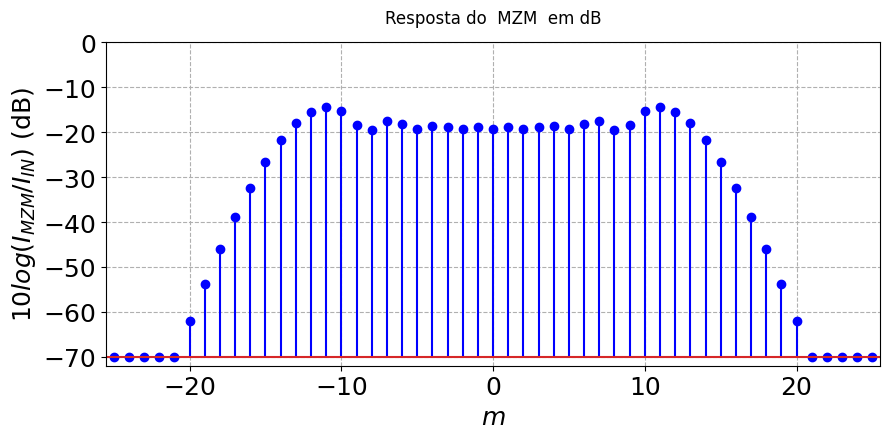

In [581]:
Amz1a = 13.48
Amz1b = 11.9
(Vector_mz) = vector_e_mzm(ind_m, Amz1a, Amz1b, Th1a, Th1b, ang1a, ang1b, P_cw)
#-------------- PLOTAR AS SLs GERADAS PELO MZM -------------------------
# usa-se a linha onde é gerada os valores do campo eletrico e o tamanho do vector mz
a = 1
# noise  = -200 # usado para plotar limite menor de ruido
(ax_mz,comb_mz,comb_mz_dBm) = find_Iout_add_noise(up_m, Vector_mz, noise)
sistem2 = ' MZM '
name_x = 'm'
sup_mz  = 0
lat_mz  = 25
ploting_sl2(ax_mz,name_x,comb_mz_dBm,sistem2, sup_mz,lat_mz)

In [582]:
# Pente do MZM a ser analisado
vec_SL = comb_mz  # Vetor de intensidade em mW
eN     = 19          # Numero de SLs a ser analisadas
analise_SD_AV(vec_SL, eN)

Tamanho do vector de saida do EOM : 61
eN = 19
SD = 0.00191
CV = 14.02531
AV = 1.96813


# Figura 3.15 (b)


Amz1a - Amz1b = 1.5700000000000003


<ipython-input-576-3fc26f7dbdd6>:85: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax.stem(axrange,comb_dBm,


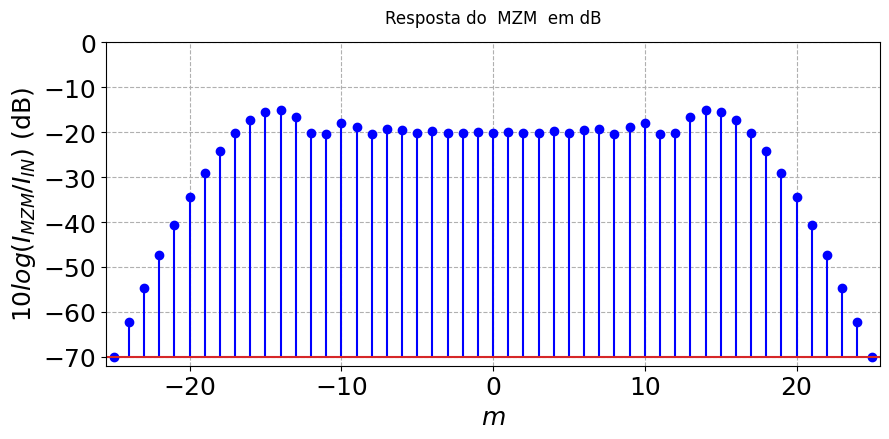

In [583]:
Amz1a = 17  #15.43
Amz1b = 15.43 #Amz1a - pi/2 #16.57#15.43     #Amz1a + pi/2 #15.43
print('Amz1a - Amz1b =',Amz1a - Amz1b)
(Vector_mz) = vector_e_mzm(ind_m, Amz1a, Amz1b, Th1a, Th1b, ang1a, ang1b, P_cw)
#-------------- PLOTAR AS SLs GERADAS PELO MZM -------------------------
# usa-se a linha onde é gerada os valores do campo eletrico e o tamanho do vector mz
a = 1
# noise  = -200 # usado para plotar limite menor de ruido
(ax_mz,comb_mz,comb_mz_dBm) = find_Iout_add_noise(up_m, Vector_mz, noise)
sistem2 = ' MZM '
name_x = 'm'
sup_mz  = 0
lat_mz  = 25
ploting_sl2(ax_mz,name_x,comb_mz_dBm,sistem2, sup_mz,lat_mz)

In [584]:
# Pente do MZM a ser analisado
vec_SL = comb_mz  # Vetor de intensidade em mW
eN     = 19         # Numero de SLs a ser analisadas
analise_SD_AV(vec_SL, eN)

print('Amz1a =',Amz1a)
print('Amz1b =',Amz1b)


Tamanho do vector de saida do EOM : 61
eN = 19
SD = 0.00121
CV = 11.57945
AV = 1.65512
Amz1a = 17
Amz1b = 15.43
